<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install imbalanced-learn -q

In [2]:
import pandas as pd
from tqdm import notebook
import re
#import nltk
import numpy as np
from numpy.random import default_rng
import transformers
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

In [3]:
import torch
import transformers

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
#import spacy
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#from spacy.pipeline import Lemmatizer
#!python -m spacy download en_core_web_sm
#nlp = spacy.load("en_core_web_sm")

In [6]:
tokenizer = transformers.BertTokenizer(
    vocab_file='datasets/ds_bert/vocab.txt')

In [7]:
RANDOM_STATE = 88

## Подготовка

In [8]:
df = pd.read_csv('datasets/toxic_comments.csv')

In [9]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


def clean_text(string):
    string = re.sub(r'[^a-z]', ' ', string, flags=re.IGNORECASE)
    string = string.split()
    string = ' '.join(string)
    return string#.lower()

In [11]:
#Обратить внимание на 6 строку

In [12]:
#df['text'].apply(clean_text).duplicated().sum()

In [13]:
#STOP_WORDS = set(stopwords.words('english'))

In [14]:
# STOP WORDS есть и в spacy, но работает коррекнто именно с nltk (в spacy стоп-слова включают в себя кавычки) "'d",
#"'ll",
#"'m"

def lemmatiza(string):
    doc = nlp(string)
    return ' '.join((i.lemma_ for i in doc if i.text not in STOP_WORDS))

In [15]:
#lemmatiza('He was walking')

In [16]:
#df['text_lemm'] = df['text'].apply(lambda x: lemmatiza(clean_text(x)))

In [17]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [18]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [19]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


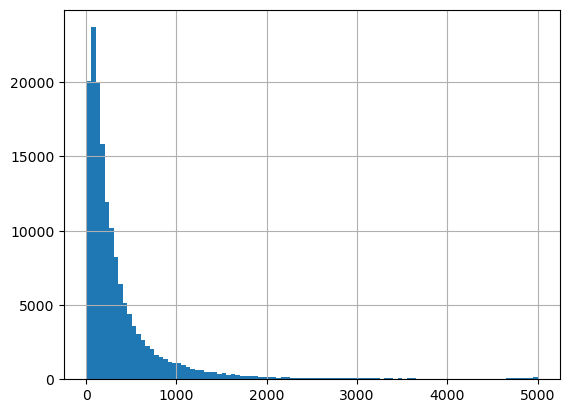

In [20]:
df['text'].apply(lambda x: len(x)).hist(bins=100);

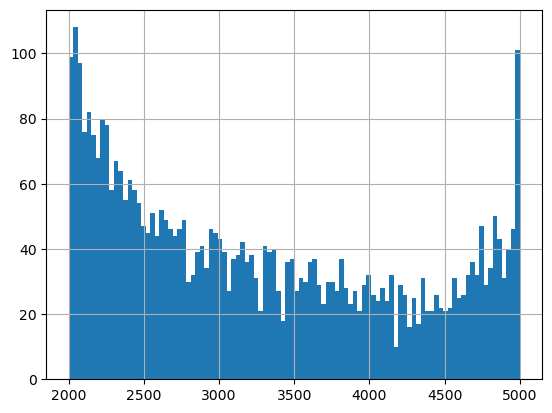

In [21]:
df[df['text'].apply(lambda x: len(x))>2000]['text'].apply(lambda x: len(x)).hist(bins=100);

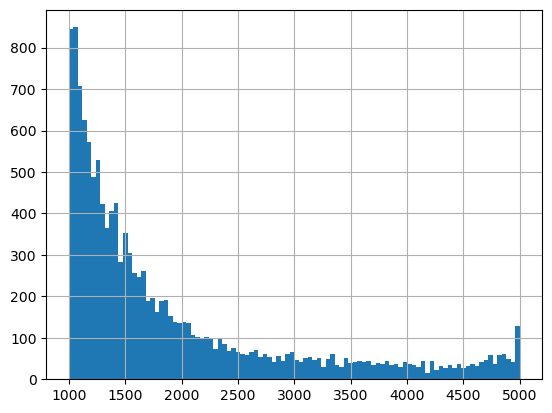

In [285]:
df[df['text'].apply(lambda x: len(x))>1000]['text'].apply(lambda x: len(x)).hist(bins=100);

In [22]:
df['toxic'].value_counts(normalize=1)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

In [23]:
df[df['text'].apply(lambda x: len(x))<2000]['toxic'].value_counts(normalize=1)

toxic
0    0.898097
1    0.101903
Name: proportion, dtype: float64

In [24]:
ratio_list = []
for i in range(100,5000,100):
    ratio_list.append(df[df['text'].apply(lambda x: len(x))<=i]['toxic'].value_counts(normalize=1)[0])

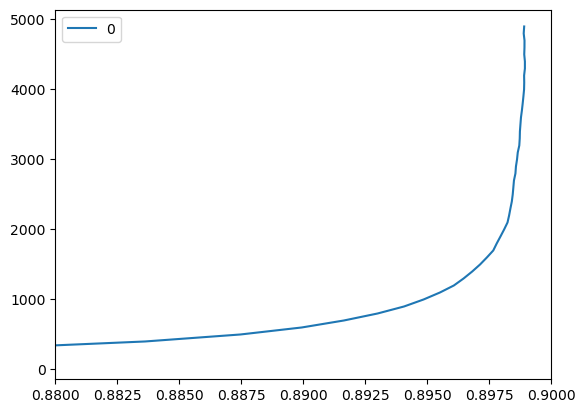

In [25]:
pd.DataFrame(range(100,5000,100) ,ratio_list).plot(xlim=(0.88,0.9));

In [26]:
def clean_text(string):
    string = re.sub(r'[^a-z]', ' ', string, flags=re.IGNORECASE)
    string = string.split()
    string = ' '.join(string)
    return string.lower()

In [27]:
df['clean'] = df['text'].apply(clean_text)

In [28]:
df['clean'].duplicated().sum()

1323

In [95]:
ratio_list1 = []
toxic = []
for i in range(50, 1500, 50):
    tokenized = df[(df['text'].apply(lambda x: len(x)==i))&(df['toxic']==0)]['text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=False))
    
    
    #ratio_list1.append(len(set(np.concatenate(tokenized.values))))
    
    tokenized_t = df[(df['text'].apply(lambda x: len(x)==i))&(df['toxic']==1)]['text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=False))

    tokenized = pd.concat([tokenized,tokenized_t])
    
    ratio_list1.append(len(set(np.concatenate(tokenized.values))))

In [ ]:
#1677s/exec

In [83]:
#set(np.concatenate(tokenized.values))

In [84]:
#pd.DataFrame(ratio_list1)

In [181]:
ratio_list1 = []

for i in notebook.tqdm(range(50, 5001, 50)):
    tokenized = df[df['text'].apply(lambda x: len(x)<=i)]['clean'].unique()
    

    tokenized = ' '.join(tokenized)
    
    ratio_list1.append(len(set(tokenized.split(sep=' '))))

  0%|          | 0/100 [00:00<?, ?it/s]

In [217]:
tokenized_2k = ' '.join(df[df['text'].apply(lambda x: len(x)<=2000)]['clean']).split(sep=' ')

In [248]:
odd = set(tokenized.split())- set(tokenized_2k)

In [282]:
list(odd)[123:128]

['selnick', 'intermidiate', 'annahar', 'werden', 'faytinga']

In [198]:
#set(tokenized.split(sep=' '))

In [120]:
df[df['text'].apply(lambda x: len(x))==df['text'].apply(lambda x: len(x)).min()]

,text,toxic,clean
119018,"""""""",1,


In [124]:
df['clean'].apply(lambda x: len(x)).min()

0

In [125]:
df[df['clean'].apply(lambda x: len(x))==df['clean'].apply(lambda x: len(x)).min()]

,text,toxic,clean
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,
6289,193.61.111.53 15:00,0,
10193,"64.86.141.133""",0,
17280,~ \n\n68.193.147.157,0,
38743,"88.104.31.21""",0,
52336,"14:53,",0,
53679,92.24.199.233|92.24.199.233]],0,
61644,"""\n\n 199.209.144.211 """,0,
82541,"""\n '''''' 2010/2013 """,0,
119018,"""""""",1,


In [126]:
df['clean'][4475]

''

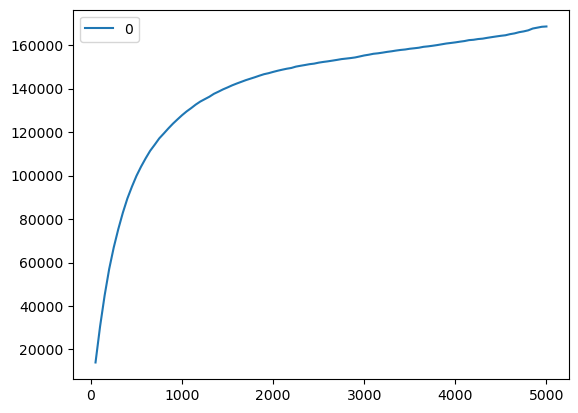

In [223]:
pd.DataFrame(ratio_list1, range(50, 5001, 50)).plot();

In [113]:
display(tokenizer.encode('what?'))
tokenizer.decode(tokenizer.encode('what?'))

[101, 1184, 136, 102]

'[CLS] what? [SEP]'

In [114]:
display(tokenizer.encode('whaaaaaaaaaat?'))
tokenizer.decode(tokenizer.encode('whaaaaaaaaaat?'))

[101, 192, 2328, 22118, 22118, 22118, 22118, 2980, 136, 102]

'[CLS] whaaaaaaaaaat? [SEP]'

In [ ]:
df=df[df['clean']!='']

In [318]:
del ratio_list
del ratio_list1
del df['clean']

In [346]:
#tokenized = df[df['text'].apply(lambda x: len(x))<2000]['text'].apply(
#        lambda x: tokenizer.encode(x, add_special_tokens=True))

In [319]:
df.shape[0]//100

1592

In [320]:
df_s = df.sample(df.shape[0]//50, random_state=RANDOM_STATE)
df_s['toxic'].value_counts(normalize=1)

toxic
0    0.905495
1    0.094505
Name: proportion, dtype: float64

In [321]:
df_s['toxic'].value_counts()

toxic
0    2884
1     301
Name: count, dtype: int64

In [322]:
df_s[df_s['text'].apply(lambda x: len(x))<2000]['text'].shape

(3106,)

In [323]:
X_train, X_test, y_train, y_test = train_test_split(
    df_s.drop(['toxic'], axis=1),
    df_s['toxic'],
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=df_s['toxic'])

In [324]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1592, 1), (1593, 1), (1592,), (1593,))

In [327]:
X_train['toxic'] = y_train

In [329]:
X_train = X_train[X_train['text'].apply(lambda x: len(x))<2000]

In [330]:
y_train = X_train['toxic']

In [333]:
X_train

,text
128094,earlier i had done so ...but now its of no use...
139265,}}\n{{unblock|This ip is shared between thousa...
126120,WHY DID THEY DELETED IT BECAUSE I MADE IT THAT...
61328,"""\n\nBut why would Xenovatis lie? Oh wait. Fev..."
126030,done! thanks for the heads up. (talk
...,...
6244,"""\n\nI totally agree.. """"Griffin is married"""" ..."
127760,"I already did: Why not?! Besides, this section..."
108912,"israeli espionage\n\nHey Rosie, thanks for you..."
101010,Reread the first five words of my prior commen...


In [336]:
#длинну убрать только после сплита
tokenized = X_train['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [337]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

640

In [338]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [340]:
padded.shape

(1555, 640)

In [341]:
#Дефолтный конфиг

In [342]:
config = transformers.BertConfig.from_dict({
      "attention_probs_dropout_prob": 0.1, 
      "directionality": "bidi", 
      "hidden_act": "gelu", 
      "hidden_dropout_prob": 0.1, 
      "hidden_size": 768, 
      "initializer_range": 0.02, 
      "intermediate_size": 3072, 
      "max_position_embeddings": 4950, #кроме этой деф - 512
      "num_attention_heads": 12, 
      "num_hidden_layers": 12, 
      "pooler_fc_size": 768, 
      "pooler_num_attention_heads": 12, 
      "pooler_num_fc_layers": 3, 
      "pooler_size_per_head": 128, 
      "pooler_type": "first_token_transform", 
      "type_vocab_size": 2, 
      "vocab_size": 30522
}
)

In [343]:
model = transformers.BertModel(config=config)

In [344]:
max_len

640

In [345]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
1/0

In [ ]:
features = np.concatenate(embeddings)

In [ ]:
features.shape

In [ ]:
1/0

In [ ]:
del lr

In [ ]:
lr = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
#дисбаланс классов
df['toxic'].value_counts()

In [ ]:
#len(lemmatiza1(clean_text(df['text'][0])))

In [ ]:
#tokenizer.decode(
tokenizer.encode('ahaaaaaaah')

In [ ]:
tokenizer.decode(tokenizer.encode(df['text'][0], add_special_tokens=True))

In [ ]:
tokenizer.encode('explanation why edit make username', add_special_tokens=True)

In [ ]:
cor = df['text'][:5].values.astype('U')

In [ ]:
clean_text(cor[0])

In [ ]:
df[df['toxic']==1]['text'].sample()

In [ ]:
def array_split(arr):
    
    arr_ler = len(arr)
    rng = default_rng()
    
    numbers = rng.choice(arr_ler, size=arr_ler//2, replace=False)

    

    return arr[numbers]##, np.delete(arr, numbers)

In [ ]:
#a = np.random.choice(tokenized, size=2, replace=False)

In [ ]:
X_train = pd.DataFrame(array_split(tokenized.values))

In [ ]:
y_train = df.loc[X_train.index,'toxic']

In [ ]:
X_test = tokenized.drop(X_train.index)

In [ ]:
y_test = df.loc[X_test.index,'toxic']

In [ ]:
X_train

In [ ]:
lr.fit(X_train.values, y_train.values)

In [ ]:
tokenized

In [ ]:
numbers

In [ ]:
random.sample

In [ ]:
random.sample(range(20), 10)

In [ ]:
df.loc[[]]

In [ ]:
np.array([1,3,4])[[0,1]]

In [ ]:
print(df.loc[43, 'text'])

In [ ]:
1/0

## Обучение

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemm'], 
    df['toxic'], 
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [ ]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 


In [ ]:
y_resample.value_counts()

In [ ]:
pd.DataFrame(y_test).value_counts()

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны